# Convolutional neural networks

In this unit we will learn about **Convolutional Neural Networks (CNNs)**, which are specifically designed for computer vision.

Computer vision is different from generic classification, because when we are trying to find a certain object in the picture, we are scanning the image looking for some specific **patterns** and their combinations. For example, when looking for a cat, we first may look for horizontal lines, which can form whiskers, and then certain combination of whiskers can tell us that it is actually a picture of a cat. Relative position and presence of certain patterns is important, and not their exact position on the image. 

To extract patterns, we will use the notion of **convolutional filters**. But first, let us load all dependencies and functions that we have defined in the previous units.

In [5]:
# 필요한 라이브러리 및 pytorch.py 파일 함수 로드
#!wget https://raw.githubusercontent.com/MicrosoftDocs/pytorchfundamentals/main/computer-vision-pytorch/pytorchcv.py
# 1회 다운후 주석처리
%pip install torchvision
%pip install torchinfo
%pip install pytorchcv

import torch
import torch.nn as nn
import torchvision
import matplotlib.pyplot as plt
from torchinfo import summary
import numpy as np
import pytorchcv
# 데이터 분활을 위한 라이브러리 추가
from torch.utils.data import Subset, DataLoader
from sklearn.model_selection import train_test_split

from pytorchcv import load_fashion_mnist, train, plot_results, plot_convolution, display_dataset
load_fashion_mnist(batch_size=128)

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


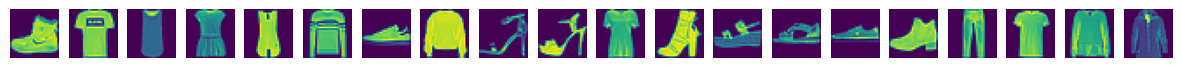

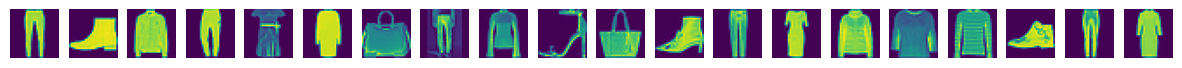

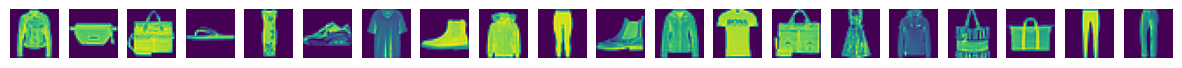

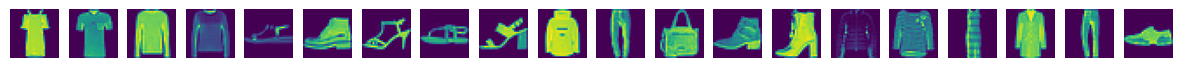

In [6]:
# 전체 데이터셋에 있는 이미지 보기(20개)
display_dataset(data_full, n=20)
# 각 데이터셋에 있는 이미지 보기 (20개씩)
display_dataset(data_train, n=20)
display_dataset(data_val, n=20)
display_dataset(data_test, n=20)

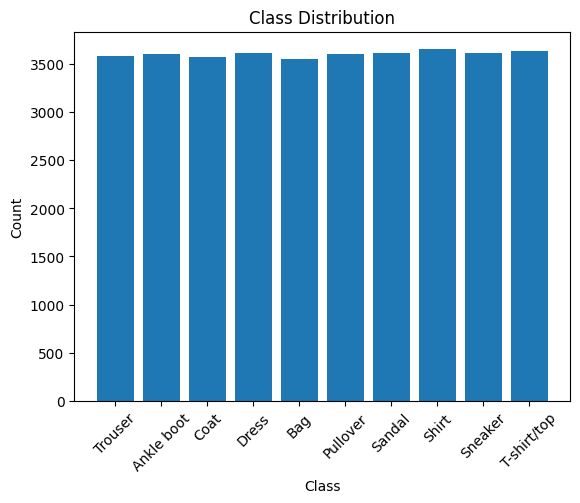

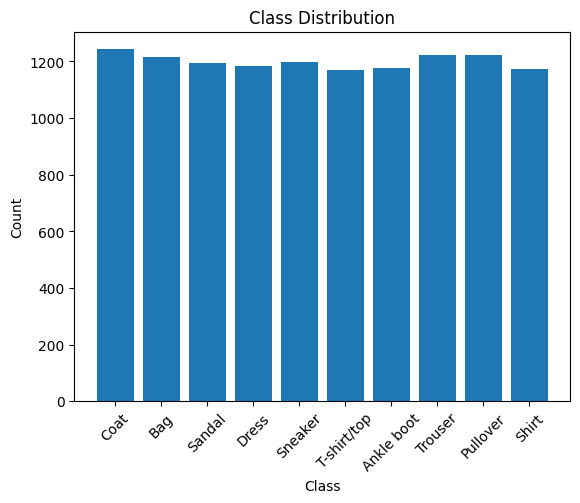

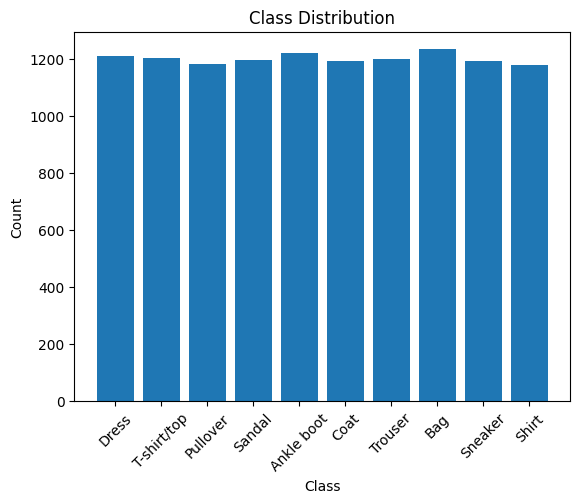

In [7]:
# 각 데이터셋 마다 어떠한 클레스에 몇개의 데이터가 있는지 표시

def plot_class_distribution(dataset):
    class_names = dataset.dataset.classes # 클래스 이름 받아오기
    class_counts = {}
    for _, label in dataset:
        class_counts[label] = class_counts.get(label, 0) + 1
    labels = [class_names[label] for label in class_counts.keys()]  # 클래스 이름으로 변환
    counts = list(class_counts.values())
    plt.bar(labels, counts)
    plt.xlabel('Class')
    plt.ylabel('Count')
    plt.title('Class Distribution')
    plt.xticks(rotation=45)  # 클래스 이름이 겹치지 않도록 회전, 이름이 겹쳐 잘 안보이는 것을 방지
    plt.show()

plot_class_distribution(data_train)
plot_class_distribution(data_val)
plot_class_distribution(data_test)
# 데이터셋이 랜덤으로 잘 분류 된것도 확인 할 수 있다.
# 10개의 클래스가 있는 것 또한 확인 할 수 있다. 

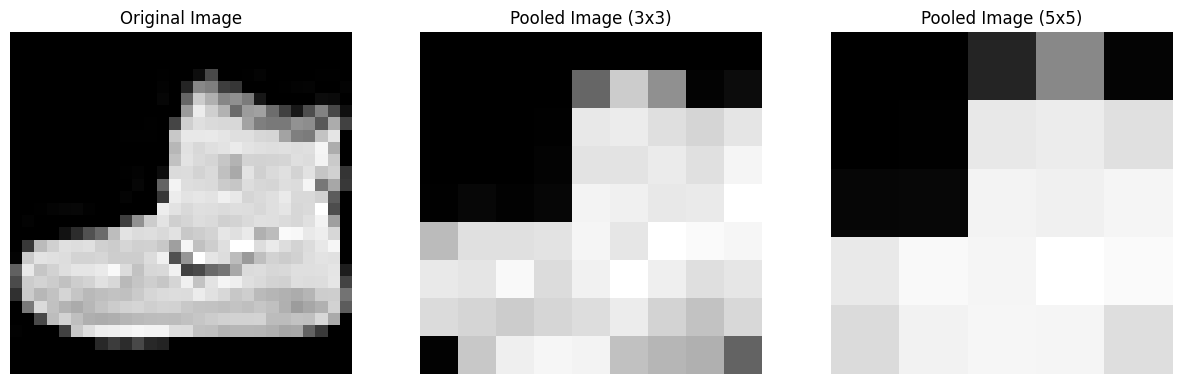

In [8]:
# 폴링 레이어
# Max Pooling을 정의, kernel_size를 각각 3과 5로 설정하여 3x3 및 5x5 Max Pooling을 적용
max_pool_3 = nn.MaxPool2d(kernel_size=3) # 3*3 max pooling
max_pool_5 = nn.MaxPool2d(kernel_size=5) # 5*5 max pooling

# 데이터셋에서 첫 번째 이미지를 가져온다
image, _ = data_full[0]

# Max Pooling을 각각 적용
pooled_image_3 = max_pool_3(image.unsqueeze(0))  # 3x3 Max Pooling 적용
pooled_image_5 = max_pool_5(image.unsqueeze(0))  # 5x5 Max Pooling 적용

# 원본 이미지와 Max Pooling 결과를 시각화
fig, ax = plt.subplots(1, 3, figsize=(15, 5))

# 원본 이미지를 표시
ax[0].imshow(image.squeeze(), cmap='gray')
ax[0].set_title('Original Image')
ax[0].axis('off')

# 3x3 Max Pooling 결과 표사
ax[1].imshow(pooled_image_3.squeeze().numpy(), cmap='gray')
ax[1].set_title('Pooled Image (3x3)')
ax[1].axis('off')

# 5x5 Max Pooling 결과 표시
ax[2].imshow(pooled_image_5.squeeze().numpy(), cmap='gray')
ax[2].set_title('Pooled Image (5x5)')
ax[2].axis('off')

plt.show()

## Convolutional filters

Convolutional filters are small windows that run over each pixel of the image and compute weighted average of the neighboring pixels.



They are defined by matrices of weight coefficients. Let's see the examples of applying two different convolutional filters over our MNIST handwritten digits.

The vertical edge filter emphasizes changes in intensity that occur vertically across the image, making it useful for detecting vertical lines and edges.

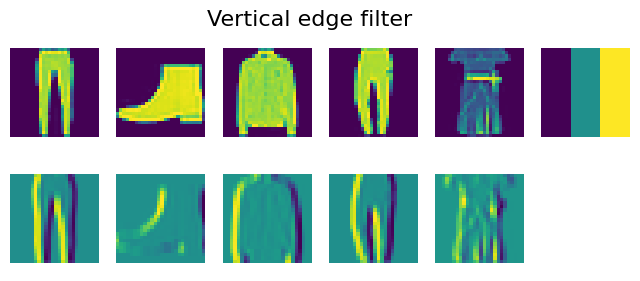

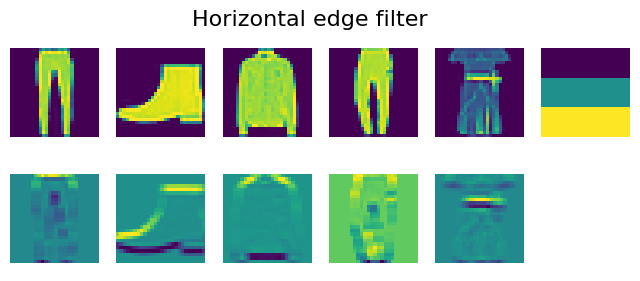

In [9]:
# 컨볼류션 레이어
plot_convolution(torch.tensor([[-1.,0.,1.],[-1.,0.,1.],[-1.,0.,1.]]),'Vertical edge filter')   # 수직선 판별하기
plot_convolution(torch.tensor([[-1.,-1.,-1.],[0.,0.,0.],[1.,1.,1.]]),'Horizontal edge filter') # 수평선 판별하기


First filter is called a **vertical edge filter**, and it is defined by the following matrix:
$$
\left(
    \begin{matrix}
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
     -1 & 0 & 1 \cr
    \end{matrix}
\right)
$$
When this filter goes over relatively uniform pixel field, all values add up to 0. However, when it encounters a vertical edge in the image, high spike value is generated. That's why in the images above you can see vertical edges represented by high and low values, while horizontal edges are averaged out.

An opposite thing happens when we apply horizontal edge filter - horizontal lines are amplified, and vertical are averaged out.

In classical computer vision, multiple filters were applied to the image to generate features, which then were used by machine learning algorithm to build a classifier. However, in deep learning we construct networks that **learn** best convolutional filters to solve classification problem.

To do that, we introduce **convolutional layers**.

## Covolutional layers

Convolutional layers are defined using `nn.Conv2d` construction. We need to specify the following:
* `in_channels` - number of input channels. In our case we are dealing with a grayscale image, thus number of input channels is 1.
* `out_channels` - number of filters to use. We will use 9 different filters, which will give the network plenty of opportunities to explore which filters work best for our scenario.
* `kernel_size` is the size of the sliding window. Usually 3x3 or 5x5 filters are used.

Simplest CNN will contain one convolutional layer. Given the input size 28x28, after applying nine 5x5 filters we will end up with a tensor of 9x24x24 (the spatial size is smaller, because there are only 24 positions where a sliding interval of length 5 can fit into 28 pixels).

After convolution, we flatten 9x24x24 tensor into one vector of size 5184, and then add linear layer, to produce 10 classes. We also use `relu` activation function in between layers. 

The Rectified Linear Unit (ReLU) activation function is one of the most commonly used activation functions in neural networks, especially in deep learning models. The function is defined mathematically as:

ReLU(x)=max(0,x)

Here’s what this means:

If x is greater than 0, the function returns x.
If x is less than or equal to 0, the function returns 0.

Properties of ReLU
Non-linear: While it looks like a linear function, ReLU introduces a non-linearity (a simple threshold at 0), which allows models to learn more complex patterns.
Computationally Efficient: It is very efficient to compute as it only requires checking if the input is positive or not.
Sparse Activation: In practice, ReLU results in sparse activations; i.e., only a subset of neurons in a layer are active at a given time.

Note: you may need to restart the kernel to use updated packages.
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 24, 24]             234
           Flatten-2                 [-1, 5184]               0
            Linear-3                   [-1, 10]          51,850
Total params: 52,084
Trainable params: 52,084
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.08
Params size (MB): 0.20
Estimated Total Size (MB): 0.28
----------------------------------------------------------------


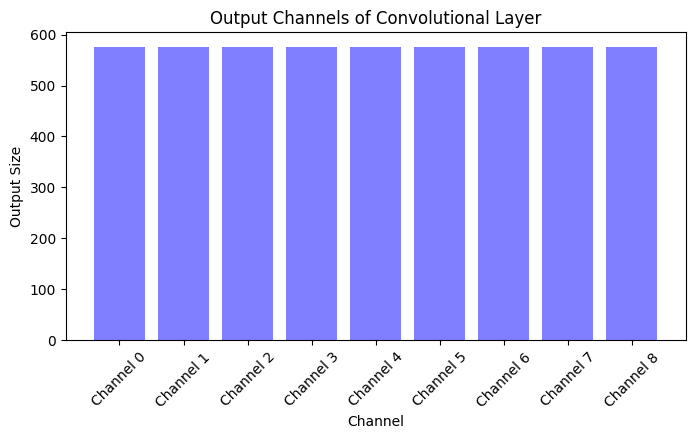

In [10]:
# 파이토치(PyTorch)를 사용하여 간단한 신경망 모델을 정의하고, 그 구조를 요약해서 출력하는 과정을 설명

import torch.nn as nn # 파이토치의 신경망 모듈(nn)을 임포트
%pip install torchsummary # 신경망 모델의 요약 정보를 제공하는 torchsummary 라이브러리를 설치
from torchsummary import summary # 설치된 torchsummary에서 summary 함수를 임포트
import matplotlib.pyplot as plt # 그래프 그리기를 위한 라이브러리 설치

class OneConv(nn.Module): # nn.Module을 상속받는 OneConv라는 새로운 클래스를 정의하는데 nn.Module은 파이토치에서 모든 신경망 모듈의 기본 클래스
    def __init__(self): # 클래스의 생성자로, OneConv 객체가 생성될 때 초기화 과정을 정의
        super(OneConv, self).__init__() # 상위 클래스인 nn.Module의 생성자를 호출하여 클래스를 적절히 초기화
        self.conv = nn.Conv2d(in_channels=1,out_channels=9,kernel_size=(5,5)) # 입력 채널이 1개, 출력 채널이 9개인 2D 컨볼루션 레이어를 정의하고, 이를 객체의 conv 속성으로 할당
        self.flatten = nn.Flatten() # 다차원 입력을 1차원 배열로 변환하는 Flatten 레이어를 정의하고, flatten 속성으로 할당
        self.fc = nn.Linear(5184,10) # 5,184개의 입력 특성을 10개의 출력 특성으로 변환하는 완전 연결 레이어(또는 선형 레이어)를 정의하고, fc 속성으로 할당

    def forward(self, x): # 모델의 순전파를 정의하는 메서드로 입력 텐서 x가 모델을 통과하는 과정을 설명
        if x.dim() == 5 and x.size(2) == 1:  # 입력 x의 차원이 예상치 못한 추가 차원을 포함하는 경우, 해당 차원을 제거
            x = x.squeeze(2) # 차원수 줄이기
        x = nn.functional.relu(self.conv(x)) # 정의된 컨볼루션 레이어를 입력 x에 적용한 후 ReLU 활성화 함수를 적용
        x = self.flatten(x) # ReLU의 출력을 flatten 레이어를 통해 평탄화
        x = nn.functional.log_softmax(self.fc(x),dim=1) # 평탄화된 벡터를 fc 레이어에 적용하고, 결과를 로그 소프트맥스 함수를 통해 처리하는데 이 함수는 다중 클래스 분류 문제에 대한 확률을 계산할 때 사용

        return x  # The final processed tensor x, which contains the log probabilities of the classes, is returned from the forward method. This output can be used by a loss function during training to compute the error and update the model weights

# Create an instance of the network
net = OneConv() # OneConv 클래스의 인스턴스를 생성

# Print the summary of the model
summary(net,input_size=(1,1,28,28)) # 생성된 모델 net의 요약 정보를 출력하는데 여기서 input_size는 모델이 기대하는 입력 데이터의 크기를 (채널 수, 높이, 너비) 형식으로 지정

def plot_layer_output_sizes(model, input_size): # 9개의 체널의 출력 시각화 하는 코드
    layers = [] # 레이어의 출력 크기를 저장할 리스트
    x = torch.zeros(input_size) # 초기화된 텐서
    for layer in model.children():
        x = layer(x) # 입력 이미지 통과 시키기
        if isinstance(layer, nn.Conv2d):  # 컨볼루션 레이어일 경우 실행해
            output_size = (x.size(0), x.size(1), x.size(2), x.size(3)) # 출력 크기 저장
            layers.append(output_size) # 리스트에 출력 크기 저장

    plt.figure(figsize=(8, 4))
    plt.title("Output Channels of Convolutional Layer") # 제목
    plt.xlabel("Channel") # x축 이름
    plt.ylabel("Output Size") # y축 이름

    #각 출력에 대한 막대 그래프 생성
    for i, size in enumerate(layers):
        plt.bar(range(size[1]), [size[2] * size[3]] * size[1], color='blue', alpha=0.5)

    # x축 레이블 설정
    plt.xticks(range(layers[0][1]), [f"Channel {i}" for i in range(layers[0][1])])
    plt.xticks(rotation=45)  # 클래스 이름이 겹치지 않도록 회전, 이름이 겹쳐 잘 안보이는 것을 방지

    plt.show()

# plot_layer_output_sizes 함수 호출
plot_layer_output_sizes(net, (1, 1, 28, 28))

You can see that this network contains around 50k trainable parameters, compared to around 80k in fully-connected multi-layered networks. This allows us to achieve good results even on smaller datasets, because convolutional networks generalize much better.

In [51]:
# PyTorch를 사용하여 신경망 모델을 학습하고 검증하는 과정을 구현

import torch # torch, torch.optim, torch.nn.functional 모듈을 임포트하는데 PyTorch에서 모델을 구성하고 최적화하는 데 필요한 함수와 클래스를 제공
from torch import optim
import torch.nn.functional as F

def train(model, train_loader, test_loader, val_loader, epochs=5): # 함수를 정의하여 모델, 학습 데이터 로더, 테스트 데이터 로더, 그리고 에폭 수를 매개변수로 받음
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 사용 가능한 경우 CUDA를 사용하고, 그렇지 않으면 CPU를 사용하도록 설정
    model.to(device) # 모델을 해당 장치로 이동
    optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam 최적화 도구를 사용하여 모델의 매개변수를 최적화하고, 학습률은 0.001로 설정
    criterion = torch.nn.CrossEntropyLoss() # 다중 클래스 분류를 위한 크로스 엔트로피 손실 함수를 사용
    
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'val_acc': [], 'val_loss': []}
    
    # 에폭 수만큼 반복하면서 모델의 학습 및 평가를 수행하는데 학습 시에는 model.train()을 호출하여 모델을 학습 모드로 설정하고, 평가 시에는 model.eval()을 호출하여 평가 모드로 설정

    try:
        for epoch in range(epochs):
            model.train() # 학습모드 
            train_loss, train_correct, train_total = 0, 0, 0
            for data, target in train_loader: # # 각 배치 데이터에 대해 데이터와 타겟을 장치로 이동시킨 후, 최적화 도구를 이용해 그래디언트를 초기화하고, 모델을 통해 예측을 수행
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                if output is None:
                    print("Warning: Model output is None.")
                    continue
                
                loss = criterion(output, target) # 손실을 계산하고, 역전파를 통해 그래디언트를 계산한 다음, 최적화 도구로 매개변수를 업데이트
                if loss is None:
                    print("Warning: Loss computation returned None.")
                    continue
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() # 정확도와 손실을 기록하여 진행 상황을 모니터링
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
            
            train_loss /= len(train_loader.dataset)
            train_acc = 100. * train_correct / train_total
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            

            # validation----------------------------------------------------------
            model.eval() # 평가모드
            val_loss, val_correct, val_total = 0, 0, 0
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    if output is None:
                        print("Warning: Model output is None during validation.")
                        continue
                        
                    loss = criterion(output, target)
                    if loss is None:
                        print("Warning: Loss computation returned None during validation.")
                        continue
                        
                    val_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    val_total += target.size(0)
                    val_correct += (predicted == target).sum().item()
                
                val_loss /= len(val_loader.dataset)
                val_acc = 100. * val_correct / val_total
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)
                
            # test-------------------------------------------------------------------------
            model.eval() #평가모드
            test_loss, test_correct, test_total = 0, 0, 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    if output is None:
                        print("Warning: Model output is None during evaluation.")
                        continue
                    
                    loss = criterion(output, target)
                    if loss is None:
                        print("Warning: Loss computation returned None during evaluation.")
                        continue
                    
                    test_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    test_total += target.size(0)
                    test_correct += (predicted == target).sum().item()
            
            test_loss /= len(test_loader.dataset)
            test_acc = 100. * test_correct / test_total
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)
            
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
                
    except Exception as e: # 에러가 발생할 경우 처리하는데 에러 발생 시 해당 에러 메시지를 출력하고 None을 반환
        print(f"An error occurred: {e}")
        return None
    
    return history # 학습과 테스트 과정에서의 손실과 정확도를 기록한 history 딕셔너리를 반환



Epoch 1/20: Train Loss: 0.0044, Train Acc: 80.79%, Val Loss: 0.0036, Val Acc: 83.69%, Test Loss: 0.0036, Test Acc: 83.62%
Epoch 2/20: Train Loss: 0.0031, Train Acc: 86.18%, Val Loss: 0.0033, Val Acc: 85.05%, Test Loss: 0.0034, Test Acc: 84.80%
Epoch 3/20: Train Loss: 0.0028, Train Acc: 87.39%, Val Loss: 0.0029, Val Acc: 86.38%, Test Loss: 0.0030, Test Acc: 86.57%
Epoch 4/20: Train Loss: 0.0026, Train Acc: 88.33%, Val Loss: 0.0027, Val Acc: 87.45%, Test Loss: 0.0028, Test Acc: 87.27%
Epoch 5/20: Train Loss: 0.0025, Train Acc: 88.90%, Val Loss: 0.0030, Val Acc: 86.55%, Test Loss: 0.0030, Test Acc: 86.01%
Epoch 6/20: Train Loss: 0.0023, Train Acc: 89.43%, Val Loss: 0.0028, Val Acc: 87.34%, Test Loss: 0.0028, Test Acc: 87.42%
Epoch 7/20: Train Loss: 0.0022, Train Acc: 89.85%, Val Loss: 0.0027, Val Acc: 87.48%, Test Loss: 0.0028, Test Acc: 87.24%
Epoch 8/20: Train Loss: 0.0021, Train Acc: 90.40%, Val Loss: 0.0026, Val Acc: 88.23%, Test Loss: 0.0026, Test Acc: 88.29%
Epoch 9/20: Train Loss: 

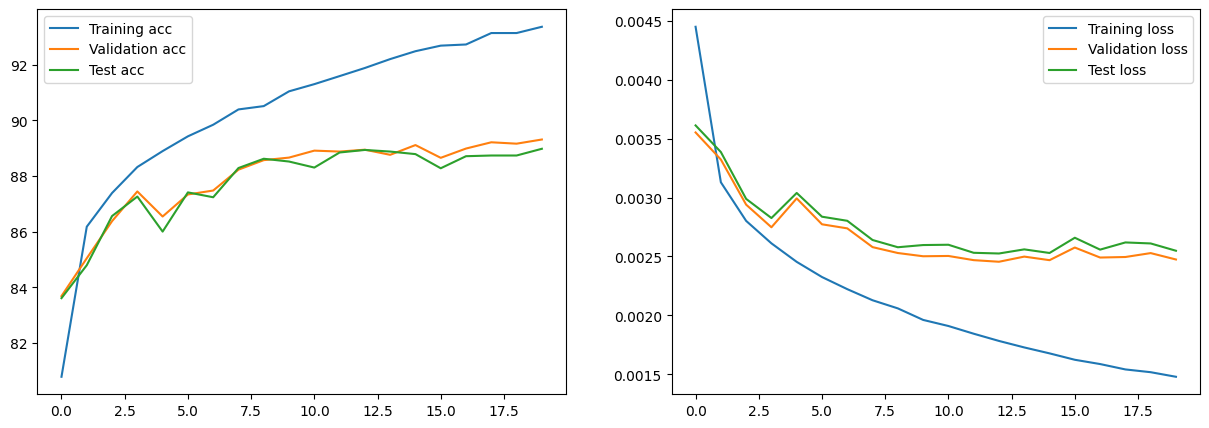

In [8]:
# 신경망 모델 net을 학습시키고 그 결과를 처리하는 과정을 보여줌

# train 함수를 호출하여 신경망 모델 net을 학습시키는데 학습 데이터 로더 train_loader, 검증 데이터 로더 val_loader, 테스트 데이터 로더 test_loader를 사용하고, 총 20 에폭(epoch) 동안 학습을 수행하고 학습 과정에서 계산된 손실과 정확도 같은 통계 정보를 hist 변수에 저장
hist = train(net,train_loader,test_loader,val_loader, epochs=20)

if hist is None: # train 함수에서 반환된 hist가 None인지 확인하는데 None은 학습 과정에서 오류가 발생했거나 예외가 처리되었음을 의미할 수 있음
    print("Training did not return any history.") # 만약 hist가 None이면, "학습이 어떠한 기록도 반환하지 않았습니다."라는 메시지를 출력하는데 이는 학습 과정에서 문제가 발생했음을 사용자에게 알리는 역할

else: # 만약 hist가 None이 아니라 유효한 데이터가 있으면
    plot_results(hist) # plot_results 함수를 호출하여 hist에 저장된 학습 결과(손실과 정확도 등)를 시각화하는데 이 함수는 일반적으로 matplotlib 같은 라이브러리를 사용하여 그래프를 그리고, 모델의 학습 진행 상황을 보여줌

마지막 test acc인 테스트 정확도가 최종 정확도가 된다. 
이준배 학생이 할 당시 Test Acc: 88.98%로 대략 89%의 정확도를 보여준다.

In [10]:
# test셋으로 예측하였을때 잘못 분류되는 클래스 갯수를 합쳐 나타낸다. 
#gpu가 있으면 cuda로 하고 없으면 cpu로 한다
default_device = 'cuda' if torch.cuda.is_available() else 'cpu'

# 클래스 이름 리스트를 자동으로 가져오는 함수 정의
def get_class_names(dataset):
    # 원본 데이터셋에서 클래스 이름 가져오기
    if hasattr(dataset, 'classes'):
        return dataset.classes
    elif hasattr(dataset.dataset, 'classes'):
        return dataset.dataset.classes
    else:
        raise AttributeError("Dataset object does not have 'classes' attribute")

# analyze_misclassified 함수 정의
def analyze_misclassified(net, test_loader, device): # 위 신경망과 테스트 로더를 사용
    class_names = get_class_names(test_loader.dataset)  # 데이터셋에서 클래스 이름 가져오기
    misclassified_counts = {class_name: 0 for class_name in class_names}  # 클래스별 잘못 분류된 이미지 수를 저장할 딕셔너리
    
    net.eval()  # 평가모드
    
    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(default_device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            # 실제 레이블과 예측된 레이블이 다른 경우 해당 클래스의 카운트를 증가
            for true_label, predicted_label in zip(labels, predicted):
                if true_label != predicted_label.item():
                    class_name = class_names[true_label.item()]
                    misclassified_counts[class_name] += 1
    
    return misclassified_counts

# 모델과 테스트 데이터 로더를 사용하여 잘못 분류된 이미지 수를 분석한다
misclassified_counts = analyze_misclassified(net, test_loader, default_device)

# 각 클래스별로 잘못 분류된 이미지 수를 출력합니다.
for class_name, count in misclassified_counts.items():
    print(f"{class_name}: {count} misclassified images")

# 모든 클래스 중 가장 많이 잘못 분류된 클래스를 찾는다
most_misclassified_class = max(misclassified_counts, key=misclassified_counts.get)
# 가장 많이 잘못 분류된 클래스와 해당 클래스의 잘못 분류된 이미지 수를 출력한다
print(f"가장 많이 잘못 분류된 클래스: {most_misclassified_class}, 이미지 수: {misclassified_counts[most_misclassified_class]}")


T-shirt/top: 223 misclassified images
Trouser: 25 misclassified images
Pullover: 173 misclassified images
Dress: 104 misclassified images
Coat: 232 misclassified images
Sandal: 34 misclassified images
Shirt: 366 misclassified images
Sneaker: 73 misclassified images
Bag: 42 misclassified images
Ankle boot: 50 misclassified images
가장 많이 잘못 분류된 클래스: Shirt, 이미지 수: 366


가장 많이 잘못 분류된 옷은 shirt이다. 아마 셔츠와 비슷한 클래스들이 많기 때문일 것이다.

We are able to achieve higher accuracy, and much faster, compared to the fully-connected networks.

We can also visualize the weights of our trained convolutional layers, to try and make some more sense of what is going on:

In [45]:
# 새로운 cnn만들기(net2)
# 1개의 컨볼루션 레이어와 1개의 멕스 폴링 레이어를 갖는 cnn
import torch.nn as nn # 파이토치의 신경망 모듈(nn)을 임포트
%pip install torchsummary # 신경망 모델의 요약 정보를 제공하는 torchsummary 라이브러리를 설치
from torchsummary import summary # 설치된 torchsummary에서 summary 함수를 임포트
import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F

class OneConvOnePool(nn.Module):
    def __init__(self):
        super(OneConvOnePool, self).__init__()
        self.conv = nn.Conv2d(in_channels=1, out_channels=9, kernel_size=5) # 컨볼루션 레이어
        self.pool = nn.MaxPool2d(kernel_size=3, stride=3) # 멕스 폴링 레이어

    def forward(self, x):
        x = F.relu(self.conv(x))
        x = self.pool(x)
        return x

# target이 1차원 텐서인 것으로 가정한다
target = torch.randint(0, 10, (10,))  # 크기가 (batch_size,)인 예시 target 텐서 생성
print(target.size())

# 네트워크의 인스턴스 생성
net2 = OneConvOnePool()

# 모델의 요약 출력
summary(net2, input_size=(1, 28, 28))

Note: you may need to restart the kernel to use updated packages.
torch.Size([10])
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1            [-1, 9, 24, 24]             234
         MaxPool3d-2           [-1, 9, 1, 8, 8]               0
Total params: 234
Trainable params: 234
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.04
Params size (MB): 0.00
Estimated Total Size (MB): 0.05
----------------------------------------------------------------


In [54]:
# 위 train함수를 net2에 맞게 변경한 train2 생성
# PyTorch를 사용하여 신경망 모델을 학습하고 검증하는 과정을 구현

import torch # torch, torch.optim, torch.nn.functional 모듈을 임포트하는데 PyTorch에서 모델을 구성하고 최적화하는 데 필요한 함수와 클래스를 제공
from torch import optim
import torch.nn.functional as F

def train2(model, train_loader, test_loader, val_loader, epochs=5): # 함수를 정의하여 모델, 학습 데이터 로더, 테스트 데이터 로더, 그리고 에폭 수를 매개변수로 받음
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu") # 사용 가능한 경우 CUDA를 사용하고, 그렇지 않으면 CPU를 사용하도록 설정
    model.to(device) # 모델을 해당 장치로 이동
    optimizer = optim.Adam(model.parameters(), lr=0.001) # Adam 최적화 도구를 사용하여 모델의 매개변수를 최적화하고, 학습률은 0.001로 설정
    criterion = torch.nn.CrossEntropyLoss() # 다중 클래스 분류를 위한 크로스 엔트로피 손실 함수를 사용
    
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': [], 'val_acc': [], 'val_loss': []}
    # 에폭 수만큼 반복하면서 모델의 학습 및 평가를 수행하는데 학습 시에는 model.train()을 호출하여 모델을 학습 모드로 설정하고, 평가 시에는 model.eval()을 호출하여 평가 모드로 설정

    try:
        for epoch in range(epochs):
            model.train() # 학습 모드
            train_loss, train_correct, train_total = 0, 0, 0
            for data, target in train_loader: # 각 배치 데이터에 대해 데이터와 타겟을 장치로 이동시킨 후, 최적화 도구를 이용해 그래디언트를 초기화하고, 모델을 통해 예측을 수행
                data, target = data.to(device), target.to(device)
                optimizer.zero_grad()
                output = model(data)
                
                if output is None:
                    print("Warning: Model output is None.")
                    continue
                
                loss = criterion(output, target) # 손실을 계산하고, 역전파를 통해 그래디언트를 계산한 다음, 최적화 도구로 매개변수를 업데이트
                if loss is None:
                    print("Warning: Loss computation returned None.")
                    continue
                
                loss.backward()
                optimizer.step()
                
                train_loss += loss.item() # 정확도와 손실을 기록하여 진행 상황을 모니터링
                _, predicted = torch.max(output.data, 1)
                train_total += target.size(0)
                train_correct += (predicted == target).sum().item()
            
            train_loss /= len(train_loader.dataset)
            train_acc = 100. * train_correct / train_total
            history['train_loss'].append(train_loss)
            history['train_acc'].append(train_acc)
            
             # validation----------------------------------------------------------
            model.eval() # 평가모드
            val_loss, val_correct, val_total = 0, 0, 0
            with torch.no_grad():
                for data, target in val_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    if output is None:
                        print("Warning: Model output is None during validation.")
                        continue
                        
                    loss = criterion(output, target)
                    if loss is None:
                        print("Warning: Loss computation returned None during validation.")
                        continue
                        
                    val_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    val_total += target.size(0)
                    val_correct += (predicted == target).sum().item()
                
                val_loss /= len(val_loader.dataset)
                val_acc = 100. * val_correct / val_total
                history['val_loss'].append(val_loss)
                history['val_acc'].append(val_acc)
            
            # test-------------------------------------------------------------------------
            model.eval() #평가모드
            test_loss, test_correct, test_total = 0, 0, 0
            with torch.no_grad():
                for data, target in test_loader:
                    data, target = data.to(device), target.to(device)
                    output = model(data)
                    if output is None:
                        print("Warning: Model output is None during evaluation.")
                        continue
                    
                    loss = criterion(output, target)
                    if loss is None:
                        print("Warning: Loss computation returned None during evaluation.")
                        continue
                    
                    test_loss += loss.item()
                    _, predicted = torch.max(output.data, 1)
                    test_total += target.size(0)
                    test_correct += (predicted == target).sum().item()
            
            test_loss /= len(test_loader.dataset)
            test_acc = 100. * test_correct / test_total
            history['test_loss'].append(test_loss)
            history['test_acc'].append(test_acc)
            
            print(f'Epoch {epoch+1}/{epochs}: Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')
                
    except Exception as e: # 에러가 발생할 경우 처리하는데 에러 발생 시 해당 에러 메시지를 출력하고 None을 반환

        print(f"An error occurred: {e}")
        return None
    
    return history # 학습과 테스트 과정에서의 손실과 정확도를 기록한 history 딕셔너리를 반환

    



Epoch 1/20: Train Loss: 0.0011, Train Acc: 95.09%, Val Loss: 0.0024, Val Acc: 89.90%, Test Loss: 0.0024, Test Acc: 89.81%
Epoch 2/20: Train Loss: 0.0011, Train Acc: 95.36%, Val Loss: 0.0024, Val Acc: 89.91%, Test Loss: 0.0024, Test Acc: 90.36%
Epoch 3/20: Train Loss: 0.0010, Train Acc: 95.37%, Val Loss: 0.0024, Val Acc: 89.92%, Test Loss: 0.0024, Test Acc: 90.22%
Epoch 4/20: Train Loss: 0.0010, Train Acc: 95.34%, Val Loss: 0.0025, Val Acc: 89.89%, Test Loss: 0.0024, Test Acc: 89.72%
Epoch 5/20: Train Loss: 0.0010, Train Acc: 95.52%, Val Loss: 0.0025, Val Acc: 89.76%, Test Loss: 0.0024, Test Acc: 89.95%
Epoch 6/20: Train Loss: 0.0010, Train Acc: 95.52%, Val Loss: 0.0026, Val Acc: 89.48%, Test Loss: 0.0025, Test Acc: 89.62%
Epoch 7/20: Train Loss: 0.0010, Train Acc: 95.76%, Val Loss: 0.0025, Val Acc: 89.88%, Test Loss: 0.0025, Test Acc: 90.26%
Epoch 8/20: Train Loss: 0.0009, Train Acc: 95.87%, Val Loss: 0.0026, Val Acc: 89.78%, Test Loss: 0.0025, Test Acc: 89.93%
Epoch 9/20: Train Loss: 

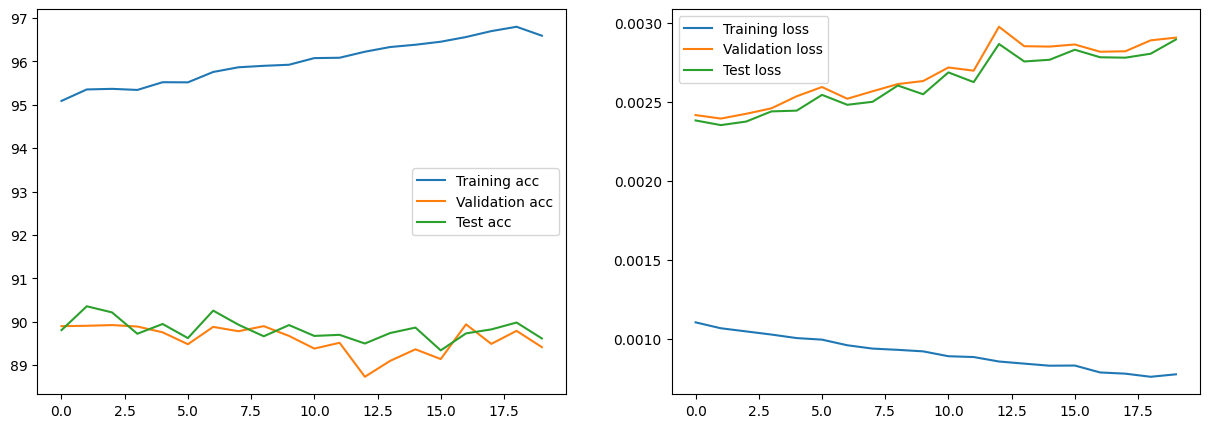

In [55]:
# 신경망 모델 net2을 학습시키고 그 결과를 처리하는 과정을 보여줌

# train2 함수를 호출하여 신경망 모델 net을 학습시키는데 학습 데이터 로더 train_loader, 검증 데이터 로더 val_loader, 테스트 데이터 로더 test_loader를 사용하고, 총 20 에폭(epoch) 동안 학습을 수행하고 학습 과정에서 계산된 손실과 정확도 같은 통계 정보를 hist 변수에 저장
hist = train2(net,train_loader,test_loader,val_loader, epochs=20)

if hist is None: # train2 함수에서 반환된 hist가 None인지 확인하는데 None은 학습 과정에서 오류가 발생했거나 예외가 처리되었음을 의미할 수 있음
    print("Training did not return any history.") # 만약 hist가 None이면, "학습이 어떠한 기록도 반환하지 않았습니다."라는 메시지를 출력하는데 이는 학습 과정에서 문제가 발생했음을 사용자에게 알리는 역할

else: # 만약 hist가 None이 아니라 유효한 데이터가 있으면
    plot_results(hist) # plot_results 함수를 호출하여 hist에 저장된 학습 결과(손실과 정확도 등)를 시각화하는데 이 함수는 일반적으로 matplotlib 같은 라이브러리를 사용하여 그래프를 그리고, 모델의 학습 진행 상황을 보여줌